In [4]:
import numpy as np
import pandas as pd
from matplotlib import colormaps
import matplotlib.colors as cls
import matplotlib.pyplot as plt
%matplotlib inline
import random
import networkx as nx

### Collecting edges from the data to bild a network

1. Data import

In [5]:
df_APS = pd.read_csv('C:/Adatok/SzKK/Emese csoportja/Greti anyaga/corrected final data/final_table_20240110.csv', sep=';', encoding="ISO-8859-1")

2. Collecting the edges

In [6]:
# selection of only the disease data
diseaseOnly = df_APS.copy()
diseaseOnly = diseaseOnly.iloc[:, 6:34]

In [7]:
# to collect all disease combinations
dis_comb_list = []

for i in range(len(diseaseOnly.index)):
    dis_inst = diseaseOnly.iloc[i,:]   
    dis_combs = str(dis_inst[dis_inst == 1].index)
    dis_combs = dis_combs.replace("'", "")
    dis_combs = dis_combs[6:-15]
    dis_comb_list.append(dis_combs)

In [8]:
dis_comb_list[:10]

['[hashimoto, diabetes_mellitus_1]',
 '[hashimoto, crohn]',
 '[hashimoto, vitiligo]',
 '[hashimoto, diabetes_mellitus_1, vitiligo]',
 '[basedow, diabetes_mellitus_1]',
 '[diabetes_mellitus_1, coeliakia]',
 '[basedow, RA]',
 '[hashimoto, early_gonadal_insufficiency, sjögren]',
 '[hashimoto, primer_biliaris_cholangitis]',
 '[hashimoto, diabetes_mellitus_1, hepatitis]']

In [9]:
# to add the results to the df
df_APS['combinations'] = pd.Series(dis_comb_list)

In [12]:
# to separate the combinations of 2, 3 or 4 diseases
dis2 = df_APS.copy()
dis2 = dis2[dis2['assoc_disease_no'] == 2]

dis3 = df_APS.copy()
dis3 = dis3[dis3['assoc_disease_no'] == 3]

dis4 = df_APS.copy()
dis4 = dis4[dis4['assoc_disease_no'] == 4]

In [32]:
# edges for the combinations of 2 diseases
edges_dis2 = dis2[['combinations']]
edges_dis2.to_csv('edges_dis2.csv')   # to save as a .csv file

# edges for the combinations of 3 diseases
edges_dis3 = dis3.groupby('combinations').count()
edges_dis3 = edges_dis3[['assoc_disease_no']].sort_values('assoc_disease_no', ascending=False)
edges_dis3.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

edges_dis3.to_csv('edges_dis3_count.csv')   # to save as a .csv file

# edges for the combinations of 4 diseases
edges_dis4 = dis4.groupby('combinations').count()
edges_dis4 = edges_dis4[['assoc_disease_no']].sort_values('assoc_disease_no', ascending=False)
edges_dis4.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

edges_dis4.to_csv('edges_dis4_count.csv')   # to save as a .csv file

Individual edges were manually separated from the combinations of 3 or 4 dieases, from the edges_dis3_count.csv and edges_dis4_count.csv files. Following this step, these edges were imported to calculate the number and the frequency of their occurrence:

In [40]:
# importing all edges
allEdges = pd.read_csv('C:/Adatok/SzKK/Emese csoportja/Greti anyaga/corrected final data/network analysis/allEdges.csv', sep=';', encoding="ISO-8859-1")

# all edges
allEdges_count = allEdges.groupby('combination').count()
allEdges_count = allEdges_count.sort_values('index', ascending=False)
allEdges_count.rename(columns = {'index':'count'}, inplace=True)

allEdges_count.sort_values('combination').to_csv('allEdges_count.csv')   # to save all edges as a .csv file

In [44]:
allEdges_count.head(10)

,count
combination,
"hashimoto, diabetes_mellitus_1",50
"hashimoto, coeliakia",47
"hashimoto, vitiligo",29
"adrenal, hashimoto",28
"hashimoto, autoimmun_gastritis",25
"hashimoto, RA",24
"hashimoto, sjögren",22
"basedow, coeliakia",20
"basedow, RA",19


3. Finding the most frequent disease combinations in the cohort

In [54]:
# to count the number of the combinations
combination_freq = df_APS.groupby('combinations').count()[['assoc_disease_no']]
combination_freq = combination_freq.sort_values('assoc_disease_no', ascending=False)
combination_freq.rename(columns = {'assoc_disease_no':'count'}, inplace=True)

# to calculate the frequency of the combinations
combination_freq['percentage'] = combination_freq['count'] / combination_freq['count'].sum() * 100

In [55]:
combination_freq.head(10)

,count,percentage
combinations,,
"[hashimoto, diabetes_mellitus_1]",36,9.473684
"[hashimoto, coeliakia]",29,7.631579
"[hashimoto, RA]",22,5.789474
"[adrenal, hashimoto]",18,4.736842
"[hashimoto, vitiligo]",18,4.736842
"[basedow, RA]",15,3.947368
"[basedow, coeliakia]",13,3.421053
"[basedow, diabetes_mellitus_1]",12,3.157895
"[hashimoto, autoimmun_gastritis]",11,2.894737


In [59]:
# proportions, relative to the entire cohort
indiv = combination_freq[combination_freq['count'] == 1]['count'].sum() / combination_freq['count'].sum() * 100
above1 = combination_freq[combination_freq['count'] > 1]['count'].sum() / combination_freq['count'].sum() * 100
above5 = combination_freq[combination_freq['count'] >= 5]['count'].sum() / combination_freq['count'].sum() * 100
above10 = combination_freq[combination_freq['count'] >= 10]['count'].sum() / combination_freq['count'].sum() * 100

print(f"Percentage of individual combinations: {indiv}")
print(f"Percentage of combinations that appear more than ones: {above1}")
print(f"Percentage of combinations that appear 5 or more times: {above5}")
print(f"Percentage of combinations that appear 10 or more times: {above10}")

Percentage of individual combinations: 17.63157894736842
Percentage of combinations that appear more than ones: 82.36842105263158
Percentage of combinations that appear 5 or more times: 63.94736842105263
Percentage of combinations that appear 10 or more times: 51.31578947368421


### Network construction

In [2]:
# list of weighted edges
weightedEdges = [('adrenal', 'RA', 3),
('adrenal', 'SLE', 1),
('adrenal', 'autoimmun_gastritis', 6),
('adrenal', 'basedow', 9),
('adrenal', 'crohn', 1),
('adrenal', 'diabetes_mellitus_1', 3),
('adrenal', 'early_gonadal_insufficiency', 2),
('adrenal', 'hashimoto', 28),
('adrenal', 'sclerosis_multiplex', 1),
('adrenal', 'sjögren', 1),
('adrenal', 'vitiligo', 4),
('autoimmun_gastritis', 'RA', 1),
('autoimmun_gastritis', 'SLE', 1),
('autoimmun_gastritis', 'coeliakia', 7),
('autoimmun_gastritis', 'colitis_ulcerosa', 1),
('autoimmun_gastritis', 'crohn', 2),
('autoimmun_gastritis', 'diabetes_mellitus_1', 4),
('autoimmun_gastritis', 'early_gonadal_insufficiency', 1),
('autoimmun_gastritis', 'haemolyticus_anaemia', 1),
('autoimmun_gastritis', 'hypopara', 1),
('autoimmun_gastritis', 'primer_antiphospholipid', 1),
('autoimmun_gastritis', 'psoriasis', 1),
('autoimmun_gastritis', 'sclerosis_multiplex', 1),
('autoimmun_gastritis', 'sjögren', 2),
('autoimmun_gastritis', 'vitiligo', 4),
('basedow', 'ITP', 1),
('basedow', 'RA', 19),
('basedow', 'SLE', 5),
('basedow', 'autoimmun_gastritis', 12),
('basedow', 'coeliakia', 20),
('basedow', 'colitis_ulcerosa', 5),
('basedow', 'crohn', 7),
('basedow', 'diabetes_mellitus_1', 18),
('basedow', 'myasthenia_gravis', 5),
('basedow', 'polymyositis', 1),
('basedow', 'primer_biliaris_cholangitis', 3),
('basedow', 'psoriasis', 4),
('basedow', 'sclerosis_multiplex', 3),
('basedow', 'sjögren', 3),
('basedow', 'systemic_sclerosis', 1),
('basedow', 'vitiligo', 9),
('coeliakia', 'SLE', 2),
('coeliakia', 'primer_antiphospholipid', 1),
('coeliakia', 'psoriasis', 4),
('coeliakia', 'sclerosis_multiplex', 1),
('coeliakia', 'sjögren', 5),
('colitis_ulcerosa', 'SLE', 2),
('colitis_ulcerosa', 'coeliakia', 2),
('colitis_ulcerosa', 'psoriasis', 1),
('colitis_ulcerosa', 'sclerosing_cholangitis', 1),
('colitis_ulcerosa', 'sclerosis_multiplex', 1),
('colitis_ulcerosa', 'sjögren', 1),
('crohn', 'psoriasis', 1),
('diabetes_mellitus_1', 'RA', 2),
('diabetes_mellitus_1', 'alopecia', 1),
('diabetes_mellitus_1', 'coeliakia', 13),
('diabetes_mellitus_1', 'colitis_ulcerosa', 2),
('diabetes_mellitus_1', 'early_gonadal_insufficiency', 1),
('diabetes_mellitus_1', 'hepatitis', 3),
('diabetes_mellitus_1', 'psoriasis', 2),
('diabetes_mellitus_1', 'sclerosing_cholangitis', 1),
('diabetes_mellitus_1', 'sjögren', 1),
('diabetes_mellitus_1', 'vitiligo', 2),
('early_gonadal_insufficiency', 'alopecia', 1),
('early_gonadal_insufficiency', 'colitis_ulcerosa', 1),
('early_gonadal_insufficiency', 'crohn', 1),
('early_gonadal_insufficiency', 'psoriasis', 2),
('early_gonadal_insufficiency', 'sjögren', 1),
('haemolyticus_anaemia', 'hepatitis', 1),
('hashimoto', 'RA', 24),
('hashimoto', 'SLE', 15),
('hashimoto', 'alopecia', 10),
('hashimoto', 'autoimmun_gastritis', 25),
('hashimoto', 'coeliakia', 47),
('hashimoto', 'colitis_ulcerosa', 10),
('hashimoto', 'crohn', 5),
('hashimoto', 'diabetes_mellitus_1', 50),
('hashimoto', 'early_gonadal_insufficiency', 12),
('hashimoto', 'haemolyticus_anaemia', 3),
('hashimoto', 'hepatitis', 7),
('hashimoto', 'hypophysitis', 1),
('hashimoto', 'myasthenia_gravis', 3),
('hashimoto', 'polymyositis', 5),
('hashimoto', 'primer_antiphospholipid', 2),
('hashimoto', 'primer_biliaris_cholangitis', 5),
('hashimoto', 'psoriasis', 12),
('hashimoto', 'sclerosis_multiplex', 2),
('hashimoto', 'sjögren', 22),
('hashimoto', 'systemic_sclerosis', 3),
('hashimoto', 'vitiligo', 29),
('hepatitis', 'RA', 1),
('hepatitis', 'SLE', 1),
('hepatitis', 'coeliakia', 1),
('hepatitis', 'sclerosing_cholangitis', 1),
('hepatitis', 'sjögren', 1),
('hypopara', 'colitis_ulcerosa', 1),
('hypopara', 'hypophysitis', 1),
('hypopara', 'mucocutan_candidiasis', 1),
('hypopara', 'sclerosing_cholangitis', 1),
('hypophysitis', 'colitis_ulcerosa', 1),
('hypophysitis', 'sclerosing_cholangitis', 1),
('primer_biliaris_cholangitis', 'coeliakia', 2),
('primer_biliaris_cholangitis', 'sjögren', 3),
('psoriasis', 'primer_antiphospholipid', 1),
('sjögren', 'RA', 2),
('sjögren', 'alopecia', 1),
('sjögren', 'psoriasis', 1),
('SLE', 'myasthenia_gravis', 2),
('vitiligo', 'alopecia', 1),
('vitiligo', 'coeliakia', 1),
('vitiligo', 'early_gonadal_insufficiency', 1),
('vitiligo', 'myasthenia_gravis', 1),
('vitiligo', 'polymyositis', 1),
('vitiligo', 'psoriasis', 1),
('vitiligo', 'sjögren', 1)]

In [3]:
# to create a graph
G = nx.Graph()
G.add_weighted_edges_from(weightedEdges)

Basic information about the graph

In [201]:
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 28
Number of edges: 115


In [202]:
# to list nodes with their degree
list(G.degree)

[('adrenal', 11),
 ('RA', 7),
 ('SLE', 8),
 ('autoimmun_gastritis', 17),
 ('basedow', 17),
 ('crohn', 6),
 ('diabetes_mellitus_1', 14),
 ('early_gonadal_insufficiency', 10),
 ('hashimoto', 22),
 ('sclerosis_multiplex', 6),
 ('sjögren', 14),
 ('vitiligo', 12),
 ('coeliakia', 13),
 ('colitis_ulcerosa', 13),
 ('haemolyticus_anaemia', 3),
 ('hypopara', 5),
 ('primer_antiphospholipid', 4),
 ('psoriasis', 11),
 ('ITP', 1),
 ('myasthenia_gravis', 4),
 ('polymyositis', 3),
 ('primer_biliaris_cholangitis', 4),
 ('systemic_sclerosis', 2),
 ('sclerosing_cholangitis', 5),
 ('alopecia', 5),
 ('hepatitis', 8),
 ('hypophysitis', 4),
 ('mucocutan_candidiasis', 1)]

### Community detection

In [186]:
# community detection with the Louvain method
communities = nx.community.louvain_communities(G, weight='weight', resolution=1.1)

In [192]:
# three communities were found
Community_1 = list(communities[0])
Community_2 = list(communities[1])
Community_3 = list(communities[2])

print(f'Community 1: {Community_1}')
print('')
print('')
print(f'Community 2: {Community_2}')
print('')
print('')
print(f'Community 3: {Community_3}')

Community 1: ['RA', 'autoimmun_gastritis', 'ITP', 'basedow', 'myasthenia_gravis', 'crohn', 'sclerosis_multiplex', 'adrenal']


Community 2: ['hepatitis', 'polymyositis', 'diabetes_mellitus_1', 'psoriasis', 'sjögren', 'coeliakia', 'hashimoto', 'vitiligo', 'alopecia', 'systemic_sclerosis', 'primer_antiphospholipid', 'haemolyticus_anaemia', 'early_gonadal_insufficiency', 'primer_biliaris_cholangitis']


Community 3: ['sclerosing_cholangitis', 'hypopara', 'mucocutan_candidiasis', 'hypophysitis', 'colitis_ulcerosa', 'SLE']


<br>

Resolution values were tested from 0.5 to 1.6: resolution=1.1 provided relatively stable, reproducible communities although SLE was switching between two communities. SLE was either within its current cluster (Community 3) or in Community 1. 

### Visualization

1. Spring layout

In [195]:
# to use degree as the size of a node
node_size = [G.degree(v)*50 for v in G]

In [211]:
# color map for coloring the nodes based on the communities
cmap = []

for node in G:
    if node in Community_3:
        cmap.append('#7570B3')
    elif node in Community_1:
        cmap.append('#E7298A')
    else:
        cmap.append('#1B9E77')

In [196]:
# dictionary of labels for visualization
label_dict = {}
label_dict['adrenal'] = 'AD'
label_dict['RA'] ='RA'
label_dict['SLE'] = 'SLE'
label_dict['autoimmun_gastritis'] = 'AIG'
label_dict['basedow'] = 'GD'
label_dict['crohn'] = 'CD'
label_dict['diabetes_mellitus_1'] = 'T1D'
label_dict['early_gonadal_insufficiency'] = 'POF'
label_dict['hashimoto'] = 'HT'
label_dict['sclerosis_multiplex'] = 'MS'
label_dict['sjögren'] = 'SS'
label_dict['vitiligo'] = 'Vit'
label_dict['coeliakia'] = 'CeD'
label_dict['colitis_ulcerosa'] = 'UC'
label_dict['haemolyticus_anaemia'] = 'AIHA'
label_dict['hypopara'] = 'hypoPT'
label_dict['primer_antiphospholipid'] = 'PAPS'
label_dict['psoriasis'] = 'PsO'
label_dict['ITP'] = 'ITP'
label_dict['myasthenia_gravis'] = 'MG'
label_dict['polymyositis'] = 'PM'
label_dict['primer_biliaris_cholangitis'] = 'PBC'
label_dict['systemic_sclerosis'] = 'SSc'
label_dict['sclerosing_cholangitis'] = 'PSC'
label_dict['alopecia'] = 'Alo'
label_dict['hepatitis'] = 'AIH'
label_dict['hypophysitis'] = 'LH'
label_dict['mucocutan_candidiasis'] = 'CMC'

Text(0.5, 1.0, 'Spring layout')

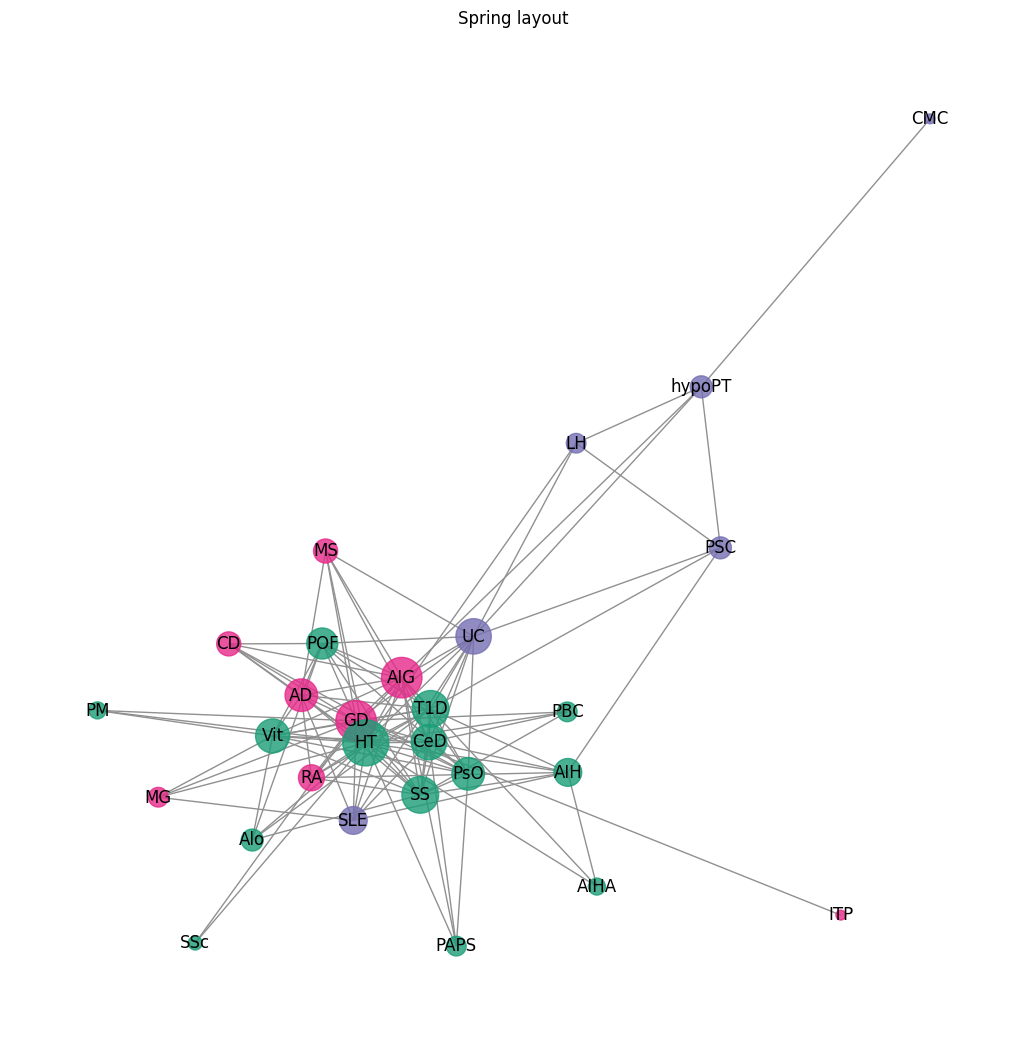

In [203]:
# basic visualization of the network - spring layout with Louvain communities
random.seed(1004)
np.random.seed(1004)

pos = nx.spring_layout(G)

plt.figure(figsize=(13,13))
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color=cmap, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color='#909090')
nx.draw_networkx_labels(G, pos=pos, labels=label_dict)
plt.axis('off')
plt.title('Spring layout')

#plt.savefig('APSnetwork_spring.tiff', dpi=300)
#plt.savefig('APSnetwork_spring.pdf', dpi=300)

2. Circular layout

In [198]:
# color map for edge coloring
usedCmap = colormaps.get_cmap('Oranges')
circular_cmap = cls.ListedColormap(usedCmap(np.linspace(0.10, 1, 49)))

In [199]:
# to assign edge color with weight
colors = nx.get_edge_attributes(G, 'weight').values()

Text(0.5, 1.0, 'Circular layout')

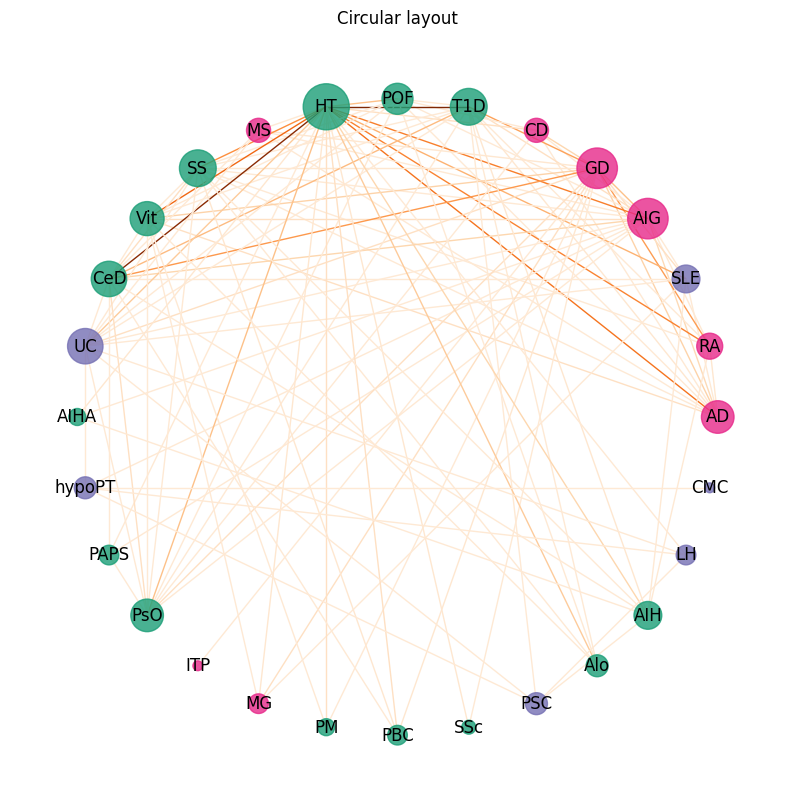

In [204]:
# circular network with Louvain communities
pos=nx.circular_layout(G)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color=cmap, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color=colors, edge_cmap=circular_cmap)
nx.draw_networkx_labels(G, pos=pos, labels=label_dict)
plt.axis('off')
plt.title('Circular layout')

#plt.savefig('APSnetwork_circular.tiff', dpi=300)
#plt.savefig('APSnetwork_circular.pdf', dpi=300)

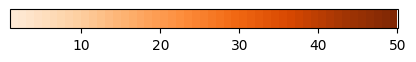

In [210]:
# legend for edge coloring
norm = cls.Normalize(vmin=1, vmax=50)

fig, ax = plt.subplots(figsize=(5, 0.5))
fig.subplots_adjust(bottom=0.5)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=circular_cmap), cax=ax, orientation='horizontal')

#fig.savefig('APSnetwork_circular_colorbar.jpg', dpi=300)

<br>

3. Kamada-Kawai layout

This layout illustrated well how HT and GD

In [29]:
# diseases that associated to HT
HT_adj = list(G.adj['hashimoto'])

# diseases that associated to GD
GD_adj = list(G.adj['basedow'])

# diseases that associated to both HT and GD
HT_GD_common = []

for disease in HT_adj:
    if disease in GD_adj:
        HT_GD_common.append(disease)

In [30]:
HT_GD_common

['adrenal',
 'RA',
 'SLE',
 'autoimmun_gastritis',
 'coeliakia',
 'colitis_ulcerosa',
 'crohn',
 'diabetes_mellitus_1',
 'myasthenia_gravis',
 'polymyositis',
 'primer_biliaris_cholangitis',
 'psoriasis',
 'sclerosis_multiplex',
 'sjögren',
 'systemic_sclerosis',
 'vitiligo']

In [24]:
# only HT associated diseases
only_HT_adj = []

for disease in HT_adj:
    if disease in HT_GD_common:
        print(f'common disease: {disease}')   # to chechk if it was correct
    else:
        only_HT_adj.append(disease)

common disease: adrenal
common disease: RA
common disease: SLE
common disease: autoimmun_gastritis
common disease: coeliakia
common disease: colitis_ulcerosa
common disease: crohn
common disease: diabetes_mellitus_1
common disease: myasthenia_gravis
common disease: polymyositis
common disease: primer_biliaris_cholangitis
common disease: psoriasis
common disease: sclerosis_multiplex
common disease: sjögren
common disease: systemic_sclerosis
common disease: vitiligo


In [25]:
only_HT_adj

['alopecia',
 'early_gonadal_insufficiency',
 'haemolyticus_anaemia',
 'hepatitis',
 'hypophysitis',
 'primer_antiphospholipid']

In [26]:
# only GD associated diseases
only_GD_adj = []

for disease in GD_adj:
    if disease in HT_GD_common:
        print(f'common disease: {disease}')   # to chechk if it was correct
    else:
        only_GD_adj.append(disease)

common disease: adrenal
common disease: RA
common disease: SLE
common disease: autoimmun_gastritis
common disease: coeliakia
common disease: colitis_ulcerosa
common disease: crohn
common disease: diabetes_mellitus_1
common disease: myasthenia_gravis
common disease: polymyositis
common disease: primer_biliaris_cholangitis
common disease: psoriasis
common disease: sclerosis_multiplex
common disease: sjögren
common disease: systemic_sclerosis
common disease: vitiligo


In [27]:
only_GD_adj

['ITP']

In [32]:
# color map for node coloring
kamkaw_node_cmap = []

for node in G:
    if node in only_HT_adj or node == 'hashimoto':
        kamkaw_node_cmap.append('orange')
    elif node in only_GD_adj or node == 'basedow':
        kamkaw_node_cmap.append('#34b8ed')
    elif node in HT_GD_common:
        kamkaw_node_cmap.append('#e6000a')
    else:
        kamkaw_node_cmap.append('#939393')

In [33]:
# color map for edge coloring
kamkaw_edge_cmap = []

for edge in list(G.edges):
    if 'hashimoto' in  edge:
        kamkaw_edge_cmap.append('#ffc263')
    elif 'basedow' in edge:
        kamkaw_edge_cmap.append('#73ccf0')
    else:
        kamkaw_edge_cmap.append('#bababa')

Text(0.5, 1.0, 'Kamada-Kawai layout')

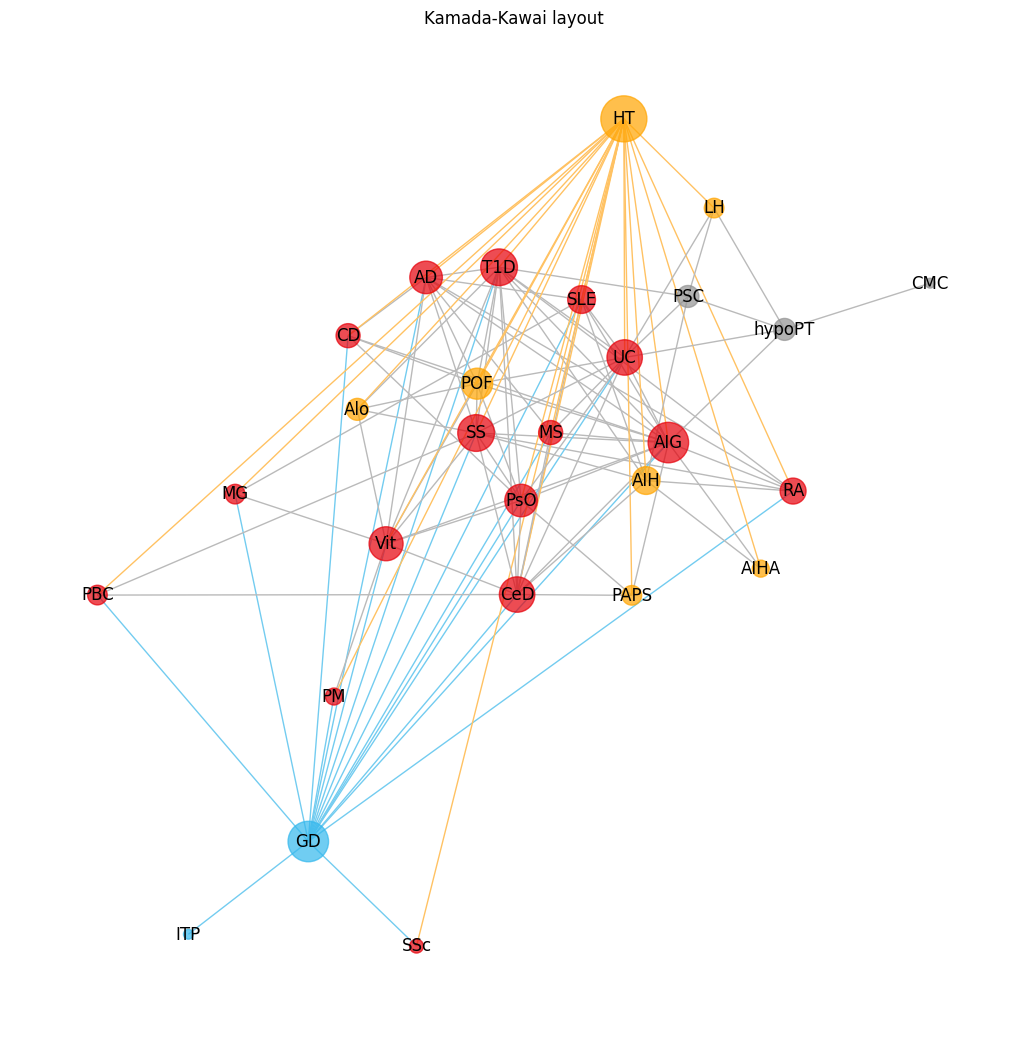

In [38]:
# kamada-kawai layout with artificial coloring
pos=nx.kamada_kawai_layout(G)

plt.figure(figsize=(13,13))
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color=kamkaw_node_cmap, alpha=0.7)
nx.draw_networkx_edges(G, pos=pos, edge_color=kamkaw_edge_cmap)
nx.draw_networkx_labels(G, pos=pos, labels=label_dict)
plt.axis('off')
plt.title('Kamada-Kawai layout')

#plt.savefig('APSnetwork__kamkaw.tiff', dpi=300)
#plt.savefig('APSnetwork__kamkaw.pdf', dpi=300)